In [1]:
import pandas as pd
import gzip
import json
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_qrels(path):
    data = []
    with gzip.open(path, 'rt') as f:
        data = [line[:-2].split(' ') for line in f]
    return pd.DataFrame(data)

# ----------------------------
def get_query_text(path):
    text = []
    with gzip.open(path, 'rt') as f:
        text = [line[:-1] for line in f]
    return text

# ----------------------------
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def get_review_data(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [43]:
traindf = get_qrels(
    'apsd/reviews_Cell_Phones_and_Accessories_5.json.gz/train.qrels.gz')
testdf = get_qrels(
    'apsd/reviews_Cell_Phones_and_Accessories_5.json.gz/test.qrels.gz')
qtext = get_query_text(
    'apsd/reviews_Cell_Phones_and_Accessories_5.json.gz/query_text.txt.gz')
itemdf = get_review_data(
    'apsd/Cell_Phones_and_Accessories_5.json.gz')

### Processing user-item review data

In [40]:
itemdf.shape

(1128437, 12)

In [41]:
idf = itemdf[['reviewerID', 'asin', 'reviewText']]
idf.columns = ['rid', 'asin', 'rtext']

In [42]:
idf

,rid,asin,rtext
0,A24E3SXTC62LJI,7508492919,Looks even better in person. Be careful to not...
1,A269FLZCB4GIPV,7508492919,When you don't want to spend a whole lot of ca...
2,AB6CHQWHZW4TV,7508492919,"so the case came on time, i love the design. I..."
3,A1M117A53LEI8,7508492919,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...
4,A272DUT8M88ZS8,7508492919,"I liked it because it was cute, but the studs ..."
...,...,...,...
1128432,A1QWMCG1FNEP3A,B01HJC7N4C,Good for viewing. But doesn't have a button or...
1128433,A3FOBEJ9UVUTR3,B01HJC7N4C,I was given the Rockrok 3D VR Glasses Headset ...
1128434,AMUEAMKB4E33M,B01HJC7N4C,Super Fun! The RockRoc 3d vr headset is waaaay...
1128435,A2EV91MMOJ3IL4,B01HJC7N4C,Love it!\n\nI've had other VR glasses which al...


In [85]:
unique_items_with_reviews = list(pd.unique(idf['asin']))
len(unique_items_with_reviews)

48186

### Processing traindf and testdf

In [90]:
# filter out items from train if they do not have reviews
trdf = traindf[traindf[2].isin(idf['asin'])]
# group items per user-query pair
trdf = trdf.groupby(0)[2].apply(list).reset_index()
# rename columns
trdf.columns = ['rid_qln', 'items']

# filter out items from test if they do not have reviews
tedf = testdf[testdf[2].isin(idf['asin'])]
# group items per user-query pair
tedf = tedf.groupby(0)[2].apply(list).reset_index()
# rename columns
tedf.columns = ['rid_qln', 'items']

In [94]:
d = []
for _,row in tqdm(trdf.iterrows(), total=len(trdf)):
    r = row['rid_qln'].split('_') + [row['items']]
    d.append(r)
trdf1 = pd.DataFrame(d, columns=['rid', 'qln', 'items'])
trdf1['qln'] = trdf1['qln'].astype(int)

d = []
for _,row in tqdm(tedf.iterrows(), total=len(tedf)):
    r = row['rid_qln'].split('_') + [row['items']]
    d.append(r)
tedf1 = pd.DataFrame(d, columns=['rid', 'qln', 'items'])
tedf1['qln'] = tedf1['qln'].astype(int)

del d

100%|██████████| 323/323 [00:00<00:00, 39616.35it/s]


In [105]:
trdf1.to_csv('data/cell-phones_train.tsv', sep='\t', index=None)

In [106]:
tedf1.to_csv('data/cell-phones_test.tsv', sep='\t', index=None)

In [103]:
_a = np.sort(pd.unique(trdf1['qln']))
print(_a.shape)
_a

(78,)


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  30,  31,  32,  33,  34,  35,  37,  38,  39,  43,
        44,  45,  47,  50,  51,  52,  55,  64,  75,  77,  79,  82,  84,
        88,  89,  90,  91,  93, 102, 103, 104, 106, 107, 108, 109, 118,
       122, 123, 124, 126, 132, 135, 137, 140, 145, 155, 156, 157, 158])

In [104]:
_b = np.sort(pd.unique(tedf1['qln']))
print(_b.shape)
_b

(11,)


array([ 29,  48,  61,  63,  83, 111, 130, 133, 136, 138, 154])

In [12]:
print(traindf.head())
print(traindf.shape)

                   0  1           2  3
0   A21O5ULBAZD8SZ_8  0  B009NLTW60  1
1   A21O5ULBAZD8SZ_8  0  B004CLYJ2I  1
2   A21O5ULBAZD8SZ_1  0  B00GJT0KS8  1
3  A21O5ULBAZD8SZ_10  0  B00FAADBHO  1
4   A21O5ULBAZD8SZ_1  0  B00C6LJXPE  1
(174087, 4)


In [13]:
traindf.groupby(3).count()

,0,1,2
3,,,
1,174087,174087,174087


In [14]:
tdf = traindf.groupby(0)[2].apply(list).reset_index()
tdf.columns = ['rid_qln', 'items']

In [15]:
print(tdf.head())
print(tdf.shape)

                    rid_qln                                             items
0   A00126503SUWI86KZBMIN_1  [B00F856178, B009LXY59E, B006FEBZRC, B0090ENC6G]
1   A00900752UZ2JAC47K2RR_1  [B008DJIGR4, B00GM5NA36, B00BVJ1M24, B00CXF1360]
2  A00900752UZ2JAC47K2RR_12                                      [B00CTVIWQW]
3  A00900752UZ2JAC47K2RR_27                                      [B00CUKEZ5E]
4   A01038432MVI9JXYTTK5T_1                          [B006NMV59E, B0092HNN8I]
(114177, 2)


In [25]:
# keep only rows with len(items) >= 3
tdf[tdf['items'].apply(lambda x: len(x)>=3)]

,rid_qln,items
0,A00126503SUWI86KZBMIN_1,"[B00F856178, B009LXY59E, B006FEBZRC, B0090ENC6G]"
1,A00900752UZ2JAC47K2RR_1,"[B008DJIGR4, B00GM5NA36, B00BVJ1M24, B00CXF1360]"
7,A01280172LF55QBT4IBHA_1,"[B008R3M8V6, B00HVPXHMA, B007TOFIJI, B00821ZB4..."
11,A01410041ZE038XXVXLBB_1,"[B009NY9U4Q, B00974L0EA, B005SUHPO6]"
15,A01534622D57NTXSH2WBR_1,"[B005JHIYLG, B005BYSV7O, B008N7TTLS]"
...,...,...
114119,AZXXVMQWISPH6_1,"[B00IIWKQX8, B00JKCH4V2, B00G4JU0EC, B00I3UWD7..."
114127,AZY9QUTCY57UV_1,"[B009HK8TQQ, B00A8RUZEG, B00ICMYI10]"
114139,AZYJTD9J82V5I_1,"[B00EZHZ77A, B00ENOB0A8, B00993E7PI]"
114170,AZZYW4YOE1B6E_1,"[B00993E7PI, B00A4EAJNA, B00BR33KK6]"


In [16]:
itlens = []
for i in list(tdf['items']):
    itlens.append(len(i))

<Axes: ylabel='Count'>

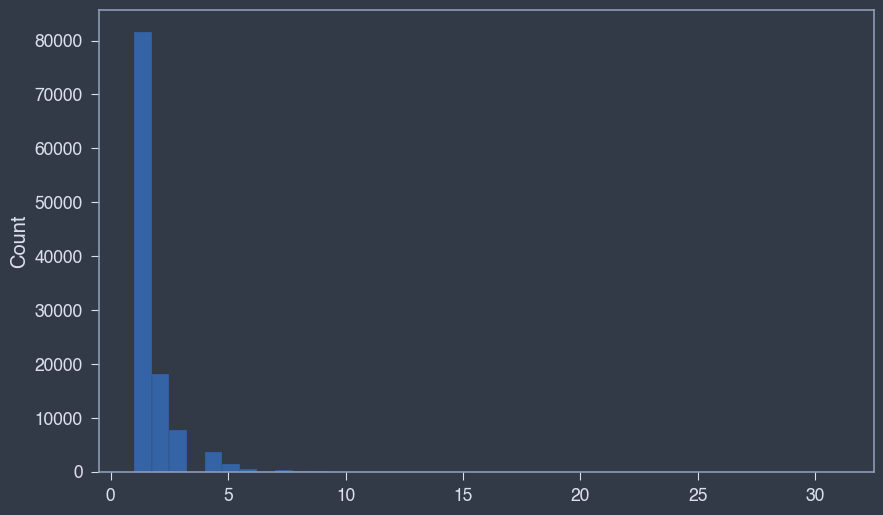

In [20]:
plt.figure(figsize=[10,6])
sns.histplot(itlens, bins=40)

In [26]:
print('max:', max(itlens))
print('min:', min(itlens))
print('avg:', f'{np.mean(itlens):.2f}')

max: 31
min: 1
avg: 1.52


### Processing user-item interaction data

In [27]:
d = []
for _,row in tqdm(tdf.iterrows(), total=len(tdf)):
    r = row['rid_qln'].split('_') + [row['items']]
    d.append(r)
tdf1 = pd.DataFrame(d, columns=['rid', 'qln', 'items'])
del d

100%|██████████| 114177/114177 [00:02<00:00, 45206.62it/s]


In [13]:
tdf1

,rid,qln,items
0,A00126503SUWI86KZBMIN,1,"[B00F856178, B009LXY59E, B006FEBZRC, B0090ENC6G]"
1,A00900752UZ2JAC47K2RR,1,"[B008DJIGR4, B00GM5NA36, B00BVJ1M24, B00CXF1360]"
2,A00900752UZ2JAC47K2RR,12,[B00CTVIWQW]
3,A00900752UZ2JAC47K2RR,27,[B00CUKEZ5E]
4,A01038432MVI9JXYTTK5T,1,"[B006NMV59E, B0092HNN8I]"
...,...,...,...
114172,AZZYW4YOE1B6E,17,[B004CLYJ0A]
114173,AZZYW4YOE1B6E,22,[B000S0B9ZC]
114174,AZZYW4YOE1B6E,37,"[B005X1Y7I2, B009USAJCC]"
114175,AZZYW4YOE1B6E,5,"[B005X1Y7I2, B00DWKK6PE, B009USAJCC]"


In [28]:
tdf2 = tdf1.copy()
tdf2['qtext'] = tdf2['qln'].apply(lambda x: qtext[int(x)])
tdf2 = tdf2[['rid', 'qtext', 'items']]

In [29]:
tdf2

,rid,qtext,items
0,A00126503SUWI86KZBMIN,cell phone accessory basic case,"[B00F856178, B009LXY59E, B006FEBZRC, B0090ENC6G]"
1,A00900752UZ2JAC47K2RR,cell phone accessory basic case,"[B008DJIGR4, B00GM5NA36, B00BVJ1M24, B00CXF1360]"
2,A00900752UZ2JAC47K2RR,cell phone accessory screen protector,[B00CTVIWQW]
3,A00900752UZ2JAC47K2RR,cell phone accessory cradle car mount,[B00CUKEZ5E]
4,A01038432MVI9JXYTTK5T,cell phone accessory basic case,"[B006NMV59E, B0092HNN8I]"
...,...,...,...
114172,AZZYW4YOE1B6E,cell phone accessory car charger,[B004CLYJ0A]
114173,AZZYW4YOE1B6E,cell phone accessory case holster clip,[B000S0B9ZC]
114174,AZZYW4YOE1B6E,electronics computer touch screen tablet acces...,"[B005X1Y7I2, B009USAJCC]"
114175,AZZYW4YOE1B6E,cell phone accessory external battery pack,"[B005X1Y7I2, B00DWKK6PE, B009USAJCC]"


### Processing user-item review data

In [30]:
idf = itemdf[['reviewerID', 'asin', 'reviewText']]

In [31]:
idf

,reviewerID,asin,reviewText
0,A24E3SXTC62LJI,7508492919,Looks even better in person. Be careful to not...
1,A269FLZCB4GIPV,7508492919,When you don't want to spend a whole lot of ca...
2,AB6CHQWHZW4TV,7508492919,"so the case came on time, i love the design. I..."
3,A1M117A53LEI8,7508492919,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...
4,A272DUT8M88ZS8,7508492919,"I liked it because it was cute, but the studs ..."
...,...,...,...
1128432,A1QWMCG1FNEP3A,B01HJC7N4C,Good for viewing. But doesn't have a button or...
1128433,A3FOBEJ9UVUTR3,B01HJC7N4C,I was given the Rockrok 3D VR Glasses Headset ...
1128434,AMUEAMKB4E33M,B01HJC7N4C,Super Fun! The RockRoc 3d vr headset is waaaay...
1128435,A2EV91MMOJ3IL4,B01HJC7N4C,Love it!\n\nI've had other VR glasses which al...


In [32]:
idf1 = idf[idf['reviewerID'].isin(tdf1['rid'])]
idf1.columns = ['rid', 'asin', 'rtext']

In [33]:
idf1

,rid,asin,rtext
2,AB6CHQWHZW4TV,7508492919,"so the case came on time, i love the design. I..."
3,A1M117A53LEI8,7508492919,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...
4,A272DUT8M88ZS8,7508492919,"I liked it because it was cute, but the studs ..."
5,A1DW2L6XCC5TJS,7508492919,The product looked exactly like the picture an...
6,AQC61R4UST7UH,7508492919,I FINALLY got my case today. It took forever t...
...,...,...,...
1128302,A2HO3OKHW50KOY,B01HCFSDOA,Very slim and soft. It fits easy in my pocket...
1128308,A1MJGVG0CE3H2N,B01HCH1DEK,great long lasting band
1128332,A2NK4K0GKSIRI,B01HDPWVJC,This is my second protector of this type. Befo...
1128392,A3TW0VH52JZD78,B01HGIMQ1E,IT MATCH THE COLOR OF MY PHONE AND MADE THE LO...


In [39]:
traindf[traindf[2].isin(idf1['asin'])]

,0,1,2,3
7,A21O5ULBAZD8SZ_12,0,B00HTK5U9K,1
10,A21O5ULBAZD8SZ_27,0,B004G1L52Q,1
11,A21O5ULBAZD8SZ_1,0,B00FZ14E3S,1
15,A2U1WQYFE8E63W_1,0,B00756KYD0,1
16,A2U1WQYFE8E63W_1,0,B00713P0BS,1
...,...,...,...,...
174074,A2A57LU86SDAQI_3,0,B00B26ZSL2,1
174076,A2A57LU86SDAQI_17,0,B003JIAA4Q,1
174079,A2DEH4K0NBYUSH_3,0,B004XUNRRQ,1
174082,A2DEH4K0NBYUSH_1,0,B004WXC4P0,1


In [38]:
traindf

,0,1,2,3
0,A21O5ULBAZD8SZ_8,0,B009NLTW60,1
1,A21O5ULBAZD8SZ_8,0,B004CLYJ2I,1
2,A21O5ULBAZD8SZ_1,0,B00GJT0KS8,1
3,A21O5ULBAZD8SZ_10,0,B00FAADBHO,1
4,A21O5ULBAZD8SZ_1,0,B00C6LJXPE,1
...,...,...,...,...
174082,A2DEH4K0NBYUSH_1,0,B004WXC4P0,1
174083,A3P57IGTOBK96O_17,0,B00GJEIO8G,1
174084,A3P57IGTOBK96O_27,0,B00EA3PCFQ,1
174085,A3P57IGTOBK96O_1,0,B008DJIIG8,1


In [22]:
iwdf = pd.read_parquet('data/item_tokens.parquet')
iwdf = iwdf[['asin', 'tokens']]

In [26]:
iwdf

,asin,tokens
0,7508492919,"[give, clear, bathroom, floor, slightly, know,..."
1,7532385086,"[recommend, ,, i, $, cool, all, their, gave, l..."
2,7887421268,"[give, recommend, ,, peeling, does, i, because..."
3,8199900164,"[rate, ,, acceptable, own, on, stopped, a, get..."
4,8288853439,"[give, recommend, ,, minutes, does, i, timed, ..."
...,...,...
48181,B01HJBS5C2,"[minutes, open, easy, texture, also, hasn, up,..."
48182,B01HJC7N4C,"[give, minutes, sample, 30, open, ##load, easy..."
48183,B01HJCN1UC,"[paired, know, easy, seller, most, also, your,..."
48184,B01HJCN55I,"[give, recommend, ,, using, does, i, because, ..."


In [34]:
uitems = list(pd.unique(traindf[2]))

In [35]:
len(uitems)

10428

In [36]:
len(pd.unique(iwdf['asin']))

48186